In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

from pyproj import Transformer
import numpy as np
import pandas as pd
import iris
import glob
import sys
import os
import cartopy.crs as ccrs
import itertools
from scipy import spatial
import numpy.ma as ma
import tilemapbase
import iris.plot as iplt
from math import cos, radians
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

from Identify_Events_Functions import *

pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
def find_amax_indy_events_v1 (df, duration, Tb0):
    
    rainfall_events = find_independent_events(df, Tb0)
    max_val, max_df = find_max_for_this_duration(rainfall_events, duration = duration)
    return max_df

def find_amax_indy_events_v2 (df, duration, Tb0):
    
    rainfall_cores = find_rainfall_core(df, duration=duration, Tb0= Tb0)
    rainfall_events_expanded= []

    for rainfall_core in rainfall_cores:
        rainfall_core_after_search1 = search1(df, rainfall_core)
        rainfall_core_after_search2 = search2(df, rainfall_core_after_search1)
        rainfall_core_after_search3 = search3(df, rainfall_core_after_search2, Tb0= Tb0)
        if len(rainfall_core_after_search3[rainfall_core_after_search3['precipitation (mm/hr)']>0.1]) ==0:
            rainfall_events_expanded.append(rainfall_core_after_search3)
    
    return rainfall_events_expanded

def find_gauge_Tb0_and_location_in_grid (gauge_num, sample_cube):
    # Get data just for this gauge
    gauge1 = tbo_vals.iloc[gauge_num]
    # Find the interevent arrival time (Tb0)
    Tb0 = int(gauge1['Critical_interarrival_time'])
    # Find the coordinates of the cell containing this gauge
    closest_point, idx_2d = find_position_obs(sample_cube,gauge1['Lat'], gauge1['Lon'], plot=False)
    
    return Tb0, idx_2d

def read_model_data(em, yr, idx_2d):
    filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}_wholeyear/{yr}_maskedcube.nc'
    cube = iris.load(filename)[0]
    # This gauge
    data = cube[:,idx_2d[0],idx_2d[1]].data
    # Data as dataframe
    df= pd.DataFrame({'precipitation (mm/hr)':data})
    df['times'] = cube[:,idx_2d[0],idx_2d[1]].coord('time').units.num2date(cube.coord('time').points)
    # New precipitation accumulation column
    df['precipitation (mm)'] = df['precipitation (mm/hr)']/2            
    return df 

In [3]:
## Needed for finding location of gauge in grid
sample_cube = iris.load(f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/bc005/2002_2020/bng_bc005a.pr200508*')[0][1,:,:]

In [4]:
# Get tb0 values at each gauge
tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

In [5]:
# em='bc005'
# yr=2003
# filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}_wholeyear/{yr}_maskedcube.nc'
# cube = iris.load(filename)[0]
# # This gauge
# data = cube[:,idx_2d[0],idx_2d[1]].data
# data

In [6]:
def find_position_obs (concat_cube, rain_gauge_lat, rain_gauge_lon, plot=False):
    lat_length = concat_cube.shape[0]
    lon_length = concat_cube.shape[1]
    
    ### Rain gauge data 
    # Convert WGS84 coordinate to BNG
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)
    # Use the transformer to convert longitude and latitude to British National Grid coordinates
    rain_gauge_lon_bng, rain_gauge_lat_bng = transformer.transform(rain_gauge_lon, rain_gauge_lat)
    
    # Create as a list
    rain_gauge_point = [('grid_latitude', rain_gauge_lat_bng), ('grid_longitude', rain_gauge_lon_bng)]
                 
    ### Model data
    # Create a list of all the tuple pairs of latitude and longitudes
    locations = list(itertools.product(concat_cube.coord('projection_y_coordinate').points,
                                       concat_cube.coord('projection_x_coordinate').points))
    
    # Find the index of the nearest neighbour of the rain gague location point in the list of locations present in concat_cube
    tree = spatial.KDTree(locations)
    closest_point_idx = tree.query([(rain_gauge_point[0][1], rain_gauge_point[1][1])], k =1)[1][0]
    
    # Create a list of all the tuple positions
    indexs_lst = [(i, j) for i in range(lat_length) for j in range(lon_length)]
    selected_index = indexs_lst[closest_point_idx]
    old_selected_index=selected_index
    
    print(selected_index)
    # Check if the selected index is masked and find a nearby valid index if necessary
    if np.ma.is_masked(concat_cube[selected_index[0], selected_index[1]].data):
        print("yep its masked")
        search_radius = 1
        found = False
        while not found and search_radius <= max(lat_length, lon_length):
            for di in range(-search_radius, search_radius + 1):
                for dj in range(-search_radius, search_radius + 1):
                    ni, nj = selected_index[0] + di, selected_index[1] + dj
                    if 0 <= ni < lat_length and 0 <= nj < lon_length:
                        if not np.ma.is_masked(concat_cube[ni, nj]):
                            closest_point_idx = indexs_lst.index((ni, nj))
                            selected_index = (ni, nj)
                            found = True
                            break
                if found:
                    break
            search_radius += 1
    print(selected_index)
            
    ######## Check by plotting         
    if plot == True:
        
#         # Get cube containing one hour worth of data
        hour_uk_cube = concat_cube

#         # Set all the values to 0
#         test_data = np.full((hour_uk_cube.shape),0,dtype = int)
#         # Set the values at the index position fond above to 1
#         test_data[selected_index[0],selected_index[1]] = 1
#         # Mask out all values that aren't 1
#         test_data = ma.masked_where(test_data<1,test_data)

#         # Set the dummy data back on the cube
#         hour_uk_cube.data = test_data

        # Find cornerpoint coordinates (for use in plotting)
        lats_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[0]
        lons_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[1]

#         # Trim the data timeslice to be the same dimensions as the corner coordinates
#         hour_uk_cube = hour_uk_cube[1:,1:]
#         test_data = hour_uk_cube.data

        # Create location in web mercator for plotting
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
        lon_rain_gauge_wm, lat_rain_gauge_wm = transformer.transform(rain_gauge_lon,rain_gauge_lat)

        # Create bounding box to centre the map on
        min_lat, max_lat, min_lon, max_lon = calculate_bounding_box(rain_gauge_lat, rain_gauge_lon, distance_km =30)
        gdf_bbox = create_geodataframe_from_bbox(min_lat, max_lat, min_lon, max_lon)
        gdf_bbox_web_mercator = gdf_bbox.to_crs(epsg=3857)

#         # Create a colormap
#         cmap = matplotlib.colors.ListedColormap(['red'])

    
        fig, ax = plt.subplots(figsize=(8,8))
        extent = tilemapbase.extent_from_frame(gdf_bbox_web_mercator)
        plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
        plot =plotter.plot(ax)
        # # Add edgecolor = 'grey' for lines
#         plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
#               linewidths=0.4, alpha = 1, cmap = cmap, edgecolors = 'grey')
        plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
        plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
        #plot =leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
        plt.plot(lon_rain_gauge_wm, lat_rain_gauge_wm, 'o', color='black', markersize = 10)     
        
        cmap = matplotlib.colors.ListedColormap(['yellow'])
        print(old_selected_index)
        hour_uk_cube = concat_cube
        # Set all the values to 0
        test_data = np.full((hour_uk_cube.shape),0,dtype = int)
        # Set the values at the index position fond above to 1
        test_data[old_selected_index[0],old_selected_index[1]] = 1
        # Mask out all values that aren't 1
        test_data = ma.masked_where(test_data<1,test_data)

        # Set the dummy data back on the cube
        hour_uk_cube.data = test_data

        # Find cornerpoint coordinates (for use in plotting)
        lats_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[0]
        lons_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[1]

        # Trim the data timeslice to be the same dimensions as the corner coordinates
        hour_uk_cube = hour_uk_cube[1:,1:]
        test_data = hour_uk_cube.data
        plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
              linewidths=0.4, alpha = 1, cmap = cmap, edgecolors = 'grey')
        
        plt.show()

        print(indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1])    
    return locations[closest_point_idx], (indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1])

In [7]:
def find_position_obs (concat_cube, rain_gauge_lat, rain_gauge_lon, plot=False):
    lat_length = concat_cube.shape[0]
    lon_length = concat_cube.shape[1]
    
    ### Rain gauge data 
    # Convert WGS84 coordinate to BNG
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)
    # Use the transformer to convert longitude and latitude to British National Grid coordinates
    rain_gauge_lon_bng, rain_gauge_lat_bng = transformer.transform(rain_gauge_lon, rain_gauge_lat)
    
    # Create as a list
    rain_gauge_point = [('grid_latitude', rain_gauge_lat_bng), ('grid_longitude', rain_gauge_lon_bng)]
                 
    ### Model data
    # Create a list of all the tuple pairs of latitude and longitudes
    locations = list(itertools.product(concat_cube.coord('projection_y_coordinate').points,
                                       concat_cube.coord('projection_x_coordinate').points))
    
    # Find the index of the nearest neighbour of the rain gague location point in the list of locations present in concat_cube
    tree = spatial.KDTree(locations)
    closest_point_idx = tree.query([(rain_gauge_point[0][1], rain_gauge_point[1][1])], k =1)[1][0]
    
    # Create a list of all the tuple positions
    indexs_lst = [(i, j) for i in range(lat_length) for j in range(lon_length)]
    selected_index = indexs_lst[closest_point_idx]
    old_selected_index=selected_index
    
    print(selected_index)
    # Check if the selected index is masked and find a nearby valid index if necessary
    if np.ma.is_masked(concat_cube[selected_index[0], selected_index[1]].data):
        print("yep its masked")
        search_radius = 1
        found = False
        while not found and search_radius <= max(lat_length, lon_length):
            for di in range(-search_radius, search_radius + 1):
                for dj in range(-search_radius, search_radius + 1):
                    ni, nj = selected_index[0] + di, selected_index[1] + dj
                    if 0 <= ni < lat_length and 0 <= nj < lon_length:
                        if not np.ma.is_masked(concat_cube[ni, nj]):
                            closest_point_idx = indexs_lst.index((ni, nj))
                            selected_index = (ni, nj)
                            found = True
                            break
                if found:
                    break
            search_radius += 1
    print(selected_index)
            
    ######## Check by plotting         
    if plot == True:
        
        # Get cube containing one hour worth of data
        hour_uk_cube = concat_cube

        # Set all the values to 0
        test_data = np.full((hour_uk_cube.shape),0,dtype = int)
        # Set the values at the index position fond above to 1
        test_data[selected_index[0],selected_index[1]] = 1
        # Mask out all values that aren't 1
        test_data = ma.masked_where(test_data<1,test_data)

        # Set the dummy data back on the cube
        hour_uk_cube.data = test_data

        # Find cornerpoint coordinates (for use in plotting)
        lats_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[0]
        lons_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[1]

        # Trim the data timeslice to be the same dimensions as the corner coordinates
        hour_uk_cube = hour_uk_cube[1:,1:]
        test_data = hour_uk_cube.data

        # Create location in web mercator for plotting
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
        lon_rain_gauge_wm, lat_rain_gauge_wm = transformer.transform(rain_gauge_lon,rain_gauge_lat)

        # Create bounding box to centre the map on
        min_lat, max_lat, min_lon, max_lon = calculate_bounding_box(rain_gauge_lat, rain_gauge_lon, distance_km =30)
        gdf_bbox = create_geodataframe_from_bbox(min_lat, max_lat, min_lon, max_lon)
        gdf_bbox_web_mercator = gdf_bbox.to_crs(epsg=3857)

        # Create a colormap
        cmap = matplotlib.colors.ListedColormap(['red'])

    
        fig, ax = plt.subplots(figsize=(8,8))
        extent = tilemapbase.extent_from_frame(gdf_bbox_web_mercator)
        plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
        plot =plotter.plot(ax)
        # # Add edgecolor = 'grey' for lines
        plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
              linewidths=0.4, alpha = 1, cmap = cmap, edgecolors = 'grey')
        plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
        plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
        #plot =leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
        plt.plot(lon_rain_gauge_wm, lat_rain_gauge_wm, 'o', color='black', markersize = 10)     
        
        
        
        # Get cube containing one hour worth of data
        hour_uk_cube = concat_cube

        # Set all the values to 0
        test_data = np.full((hour_uk_cube.shape),0,dtype = int)
        # Set the values at the index position fond above to 1
        test_data[old_selected_index[0],old_selected_index[1]] = 1
        # Mask out all values that aren't 1
        test_data = ma.masked_where(test_data<1,test_data)

        # Set the dummy data back on the cube
        hour_uk_cube.data = test_data

        # Find cornerpoint coordinates (for use in plotting)
        lats_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[0]
        lons_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[1]

        # Trim the data timeslice to be the same dimensions as the corner coordinates
        hour_uk_cube = hour_uk_cube[1:,1:]
        test_data = hour_uk_cube.data

        # Create location in web mercator for plotting
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
        lon_rain_gauge_wm, lat_rain_gauge_wm = transformer.transform(rain_gauge_lon,rain_gauge_lat)

        # Create bounding box to centre the map on
        min_lat, max_lat, min_lon, max_lon = calculate_bounding_box(rain_gauge_lat, rain_gauge_lon, distance_km =30)
        gdf_bbox = create_geodataframe_from_bbox(min_lat, max_lat, min_lon, max_lon)
        gdf_bbox_web_mercator = gdf_bbox.to_crs(epsg=3857)

        # Create a colormap
        cmap = matplotlib.colors.ListedColormap(['yellow'])

        # # Add edgecolor = 'grey' for lines
        plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
              linewidths=0.4, alpha = 1, cmap = cmap, edgecolors = 'grey')
        plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
        plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
        #plot =leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
        plt.plot(lon_rain_gauge_wm, lat_rain_gauge_wm, 'o', color='black', markersize = 10)     
        fig.tight_layout()
        fig.savefig("fig.jpg")

        print(indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1])    
    return locations[closest_point_idx], (indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1])

(282, 312)
yep its masked
(281, 311)
281 311


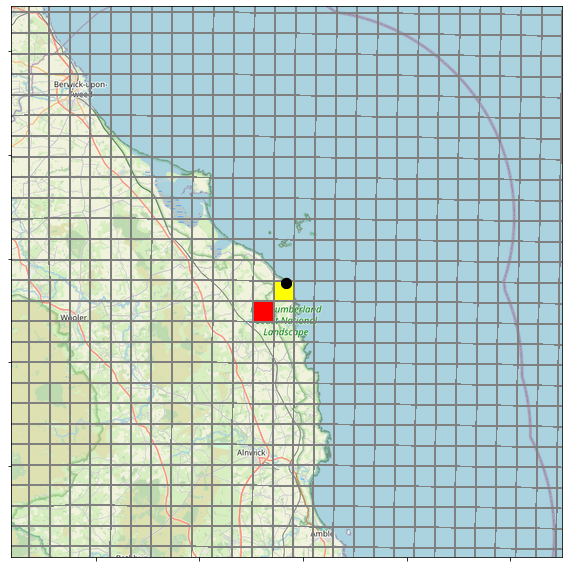

In [8]:
gauge1 = tbo_vals.iloc[6]
# Find the interevent arrival time (Tb0)
Tb0 = int(gauge1['Critical_interarrival_time'])
import numpy.ma as ma
import math
# Find the coordinates of the cell containing this gauge
closest_point, idx_2d = find_position_obs(sample_cube,gauge1['Lat'], gauge1['Lon'], plot=True)

### Get Tb0 values from gauge data

### Get model data: 30 mins data for one ensemble member 2001-2019

For 5 hour duration events: Find all independent AMAX producing events at grid cells containing a rain gauge

In [331]:
def is_sequential(numbers):
    return all(numbers[i] - numbers[i - 1] == 1 for i in range(1, len(numbers)))

In [349]:
# Loop through gauges
for gauge_num in [37]:
    
    # Find the Tb0 and index of this gauge
    Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(gauge_num, sample_cube)
    
    for em in ['bc005']:
        directory = f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option2"
        files = [f for f in os.listdir(directory) if f.endswith('.csv')]
        files = np.sort(files)
        for file in files:
            test = pd.read_csv(directory+ '/'+ file)
            if test['Unnamed: 0'].is_monotonic_increasing ==False:
                print(f"not monotonic: {file}")
            if not is_sequential(test['Unnamed: 0']):
                print(f"not sequential {file}")


In [351]:
# Loop through gauges
for gauge_num in [56]:
    
    # Find the Tb0 and index of this gauge
    Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(gauge_num, sample_cube)
    
    for em in ['bc005']:
        
        # Make directory to store outputs
        if not os.path.isdir(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option1"):
            os.makedirs(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option1")
        if not os.path.isdir(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option2"):
            os.makedirs(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option2")
        
        for yr in range(2001,2020):
            
            if not all(os.path.exists(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/{option}/{duration}hrs_{yr}_v1.csv") for option in ['Option1', 'Option2'] for duration in [0.5, 1, 2, 3, 6, 12, 24]):

                # Get data for this ensemble member and year, at the grid cell containing this gauge
                df =read_model_data(em, yr, idx_2d)

                # Loop through duration
                for duration in [0.5, 1, 2, 3, 6, 12, 24]:    
                    print(f"Finding the AMAX for {duration}hr events in em {em} for the year {yr}")
                    
                    if os.path.isfile(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option1/{duration}hrs_{yr}_v1.csv"):
                        print("Option 1 already exists")
                    else:
                        event_v1 = find_amax_indy_events_v1(df, duration =duration, Tb0=Tb0)
                        if len(event_v1)>1:
                            event_v1.to_csv(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option1/{duration}hrs_{yr}_v1.csv")
                            print(f"Option 1: length with my method {len(event_v1)/2}, from {event_v1.index[0]}  to {event_v1.index[-1]} ")
                    
                    if os.path.isfile(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option2/{duration}hrs_{yr}_v2_part0.csv"):
                        print("Option 2 already exists")
                    else:
                        events_v2 = find_amax_indy_events_v2(df, duration =duration, Tb0=Tb0)
                        for num, event in enumerate(events_v2):
                            if len(event)>1:
                                if event.index.is_monotonic_increasing ==False:
                                    print(f"monotonic: {duration}, {yr}")
                                if not is_sequential(event.index):
                                    print(f"not sequential {file}")
                                event.to_csv(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option2/{duration}hrs_{yr}_v2_part{num}.csv")
                                print(f"Option 2: length with RVH method {len(events_v2[num])/2}, from {events_v2[num].index[0]}  to {events_v2[num].index[-1]} ")
                        
            else:
                print(f"all files already exist for {yr}")

Finding the AMAX for 0.5hr events in em bc005 for the year 2001


KeyError: nan

In [6]:
# # Extract 'dataframe' items for dictionaries with 'year' == 2005
# dataframes_2h = [event['Event'] for event in events_v1_ls if event['Duration'] ==2]

## Summary statistic

In [ ]:
def calculate_normalized_com(times, intensities):
    """
    Calculate the normalized center of mass for a rainfall event.
    
    Parameters:
        times (np.array): Array of time points (scaled to the duration of the event, e.g., as fractions of the total duration)
        intensities (np.array): Array of rainfall intensities at the corresponding times
    
    Returns:
        float: The normalized center of mass of the rainfall event.
    """
    intensities = intensities.astype(float)
    
    # Normalize time values to a scale of 0 to 1 (assuming times are already normalized if not multiply by (times - times.min()) / (times.max() - times.min()))
    normalized_times = (times - times.min()) / (times.max() - times.min())
    
    # Calculate the weighted average of normalized time points
    center_of_mass = np.sum(normalized_times * intensities) / np.sum(intensities)
    
    return center_of_mass

# Example usage:
times = np.array([1, 2, 3, 4, 5])  # e.g., time points of the event
intensities = np.array([5, 15, 25, 15, 5])  # rainfall intensities

com = calculate_normalized_com(times, intensities)
print("Normalized Center of Mass of the rainfall event:", com)


In [62]:
def calculate_p_dry(rainfall_amounts, total_duration):
    """
    Calculate the proportion of dry periods in a rainfall event.

    Parameters:
        rainfall_amounts (np.array): Array of rainfall amounts at consistent time intervals.
        total_duration (float): Total duration of the rainfall event in the same units as the time intervals.

    Returns:
        float: The proportion of the total duration that was dry (no rainfall).
    """
    # Calculate the number of dry periods (intervals with zero rainfall)
    dry_periods = np.sum(rainfall_amounts < 0.1)
    
    # Assuming the time interval between rainfall measurements is constant and the sum of intervals equals total_duration
    p_dry = dry_periods / len(rainfall_amounts)

    return p_dry

# Example usage:
rainfall_amounts = np.array([0, 0, 5, 0, 2, 0, 0, 0, 3, 0])  # rainfall amounts, where 0 indicates a dry period
total_duration = 10  # total number of intervals, which could be in hours, minutes, etc.

p_dry = calculate_p_dry(rainfall_amounts, total_duration)
print("Proportion of Dry Period (Pdry):", p_dry)


Proportion of Dry Period (Pdry): 0.7


In [71]:
def calculate_effective_intensity(rainfall_amounts, total_duration):
    """
    Calculate the effective rainstorm intensity, ignoring dry periods.

    Parameters:
        rainfall_amounts (np.array): Array of rainfall amounts at consistent time intervals.
        total_duration (float): Total duration of the rainfall event in the same units as the time intervals.

    Returns:
        float: Effective rainstorm intensity.
    """
    # Total Rainstorm Volume (sum of all rainfall amounts)
    total_volume = np.sum(rainfall_amounts)

    # Effective Rainstorm Duration (count of non-dry intervals)
    effective_duration = np.sum(rainfall_amounts > 0.1)  # Assuming time intervals are uniform

    # Calculate effective intensity
    if effective_duration > 0:
        effective_intensity = total_volume / effective_duration
    else:
        effective_intensity = 0

    return effective_intensity

# Example usage:
rainfall_amounts = np.array([0, 0, 5, 0, 2, 0, 0, 0, 3, 0])  # rainfall amounts, where 0 indicates a dry period
total_duration = 10  # total number of intervals, which could be in hours, minutes, etc.

effective_intensity = calculate_effective_intensity(rainfall_amounts, total_duration)
print("Effective Rainstorm Intensity (Ie):", effective_intensity)


Effective Rainstorm Intensity (Ie): 3.3333333333333335


In [ ]:
intensities = event_v2['precipitation (mm)']
times = np.array(range(0,len(intensities)))
com = calculate_normalized_com(times, intensities)
print("Center of Mass of the rainfall event:", com)

In [65]:
p_dry = calculate_p_dry(np.array(intensities), len(intensities))
print("Proportion of Dry Period (Pdry):", p_dry)

Proportion of Dry Period (Pdry): 0.85


In [72]:
effective_intensity = calculate_effective_intensity(np.array(intensities), len(intensities))
print("Effective Rainstorm Intensity (Ie):", effective_intensity)

Effective Rainstorm Intensity (Ie): 4.5476226806640625


## Plotting

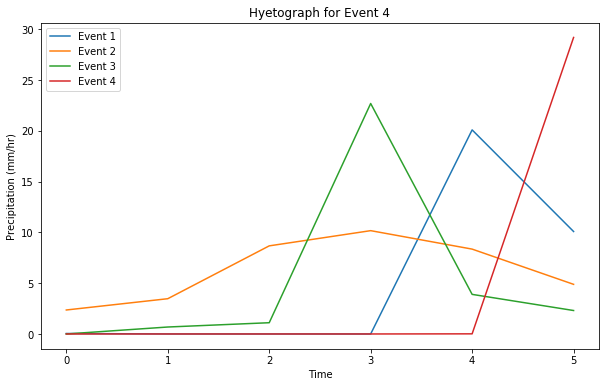

In [82]:
# Assuming each event's DataFrame is stored in 'dataframe' key of dictionaries in the list
# Example event data retrieval
events_dataframes = [event['Event'] for event in events_v1_ls if event['Duration'] ==2]

# Plotting hyetographs
plt.figure(figsize=(10, 6))
for i, event_df in enumerate(events_dataframes):
    event_df.reset_index(inplace=True, drop=True)
    plt.plot(event_df.index, event_df['precipitation (mm/hr)'], label=f'Event {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Precipitation (mm/hr)')
    plt.title(f'Hyetograph for Event {i+1}')
    plt.legend()
plt.show()

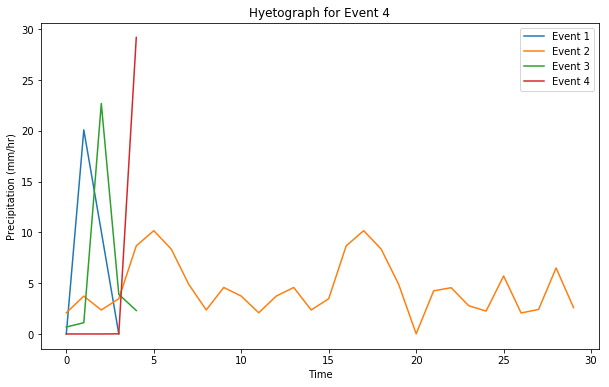

In [85]:
# Assuming each event's DataFrame is stored in 'dataframe' key of dictionaries in the list
# Example event data retrieval
events_dataframes = [event['Event'] for event in events_v2_ls if event['Duration'] ==2]

# Plotting hyetographs
plt.figure(figsize=(10, 6))
for i, event_df in enumerate(events_dataframes):
    event_df.reset_index(inplace=True, drop=True)
    plt.plot(event_df.index, event_df['precipitation (mm/hr)'], label=f'Event {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Precipitation (mm/hr)')
    plt.title(f'Hyetograph for Event {i+1}')
    plt.legend()
plt.show()

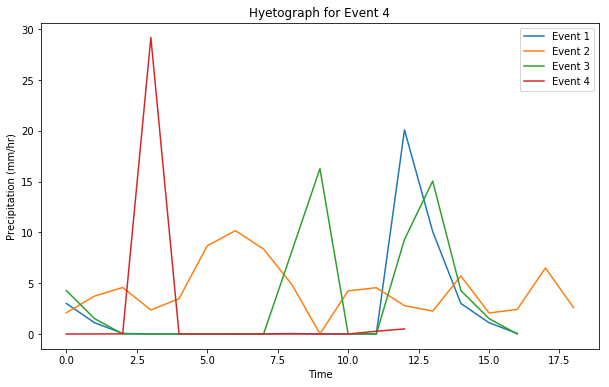

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming each event's DataFrame is stored in 'dataframe' key of dictionaries in the list
# Example event data retrieval
events_dataframes = [event['Event'] for event in events_v2_ls if event['Duration'] ==6]

# Plotting hyetographs
plt.figure(figsize=(10, 6))
for i, event_df in enumerate(events_dataframes):
    event_df.reset_index(inplace=True, drop=True)
    plt.plot(event_df.index, event_df['precipitation (mm/hr)'], label=f'Event {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Precipitation (mm/hr)')
    plt.title(f'Hyetograph for Event {i+1}')
    plt.legend()
plt.show()


### Trying to work out why results for year 2002 and duration 2hr and em BC005 are so different

In [113]:
df =read_model_data(em, yr, idx_2d)

In [ ]:
# SO in the set of independent events algorithm identifies there is an event from 1578-1627
# The event identified by algorithm v1 was 1594-1599
# The event identified by algorithm v1 was 1591-1609

# WHy does V1 trim it like it does?

In [112]:
rainfall_events = find_independent_events(df, Tb0)
rainfall_events

[{'start_index': 221,
  'end_index': 247,
  'event_data':      precipitation (mm/hr)  precipitation (mm)  is_dry  consecutive_dry  \
  221                  0.227               0.114   False              221   
  222                  2.191               1.096   False                0   
  223                  0.983               0.492   False                0   
  224                  0.309               0.155   False                0   
  225                  0.449               0.225   False                0   
  226                  0.287               0.143   False                0   
  227                  0.002               0.001    True                0   
  228                  0.152               0.076    True                1   
  229                  0.265               0.133   False                2   
  
       starts_after_dry_period  
  221                     True  
  222                    False  
  223                    False  
  224                    False  
  225 

In [126]:
duration = 2
# to account for each being 30mins
window_length = duration *2
one_independent_event_df = rainfall_events[9]['event_data']
one_independent_event_df['Rolling_Sum'] = one_independent_event_df['precipitation (mm)'].rolling(window=window_length).sum()

# Find the index of the maximum total rainfall within a 2-hour window
max_rainfall_end_index = one_independent_event_df['Rolling_Sum'].idxmax()

max_rainfall_end_pos = one_independent_event_df.index.get_loc(max_rainfall_end_index)

# Calculate the start position of the 2-hour window with the most rainfall
# This accounts for 3 periods before the max index, as the max index is inclusive
max_rainfall_start_pos = max(0, max_rainfall_end_pos - window_length)  # Ensure it doesn't go below the DataFrame's range

# Extract the 2-hour window using iloc
max_rainfall_window = one_independent_event_df.iloc[max_rainfall_start_pos:max_rainfall_end_pos]
max_rainfall_window


,precipitation (mm/hr),precipitation (mm),is_dry,consecutive_dry,starts_after_dry_period,Rolling_Sum
1595,3.473,1.737,False,0,False,7.073
1596,8.678,4.339,False,0,False,9.548
1597,10.176,5.088,False,0,False,12.345
1598,8.358,4.179,False,0,False,15.342


In [ ]:
duration = 2
# to account for each being 30mins
window_length = duration *2

# to store the outcomes
max_val = 0
max_idx = 'PlaceHolder'
max_df = pd.DataFrame({})

# Search each of the independent rainfall events for a maximum value at this duration
for idx in range(1,len(rainfall_events)):

    # Get this independent event
    one_independent_event_df = rainfall_events[idx]['event_data']

    # Filter out events shorter than this duration
    if len(one_independent_event_df)>window_length:

        # Calculate the rolling sum of precipitation for each 2-hour window
        one_independent_event_df['Rolling_Sum'] = one_independent_event_df['precipitation (mm)'].rolling(window=window_length).sum()

        # Find the index of the maximum total rainfall within a 2-hour window
        max_rainfall_end_index = one_independent_event_df['Rolling_Sum'].idxmax()

        # Find the position of max_rainfall_end_index in the DataFrame's index
        max_rainfall_end_pos = one_independent_event_df.index.get_loc(max_rainfall_end_index)

        # Calculate the start position of the 2-hour window with the most rainfall
        # This accounts for 3 periods before the max index, as the max index is inclusive
        max_rainfall_start_pos = max(0, max_rainfall_end_pos - window_length-1)  # Ensure it doesn't go below the DataFrame's range

        # Extract the 2-hour window using iloc
        max_rainfall_window = one_independent_event_df.iloc[max_rainfall_start_pos:max_rainfall_end_pos + 1]

        # Display the results
        # print(f"The 2-hour window with the most rainfall ends at {max_rainfall_end_index} and includes:")

        # If the maximum value for this duration in this independent event, is bigger than the biggest one that came before
        # then save these results
        if one_independent_event_df['Rolling_Sum'].max() > max_val:
            max_val = one_independent_event_df['Rolling_Sum'].max()
            max_df = max_rainfall_window
            max_idx = idx
        else:
            pass



In [ ]:
def find_amax_indy_events_v1 (df, duration, Tb0):
    
    rainfall_events = find_independent_events(df, Tb0)
    max_val, max_df, max_idx = find_max_for_this_duration(rainfall_events, duration = duration)
    return max_df

## Create dimensionless profiles

In [96]:
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np

# Assuming each event is a DataFrame in a list `events_dataframes`
# Each DataFrame has a 'time' column (in any consistent unit) and a 'precipitation' column

# Target number of intervals for the dimensionless representation
target_intervals = 12

dimensionless_events = []

for event_df in events_dataframes:
    # Normalize time scale from 0 to 1 for the event
    normalized_time = np.linspace(0, 1, num=len(event_df))
    
    # Target time scale with uniform length
    target_time_scale = np.linspace(0, 1, num=target_intervals)
    
    # Interpolation function for precipitation
    interp_func = interp1d(normalized_time, event_df['precipitation (mm/hr)'], kind='linear')
    
    # Interpolated precipitation values at the target time scale
    interpolated_precip = interp_func(target_time_scale)
    
    # Create a new DataFrame for the dimensionless event
    dimensionless_event_df = pd.DataFrame({
        'time': target_time_scale,
        'precipitation (mm/hr)': interpolated_precip
    })
    
    dimensionless_events.append(dimensionless_event_df)


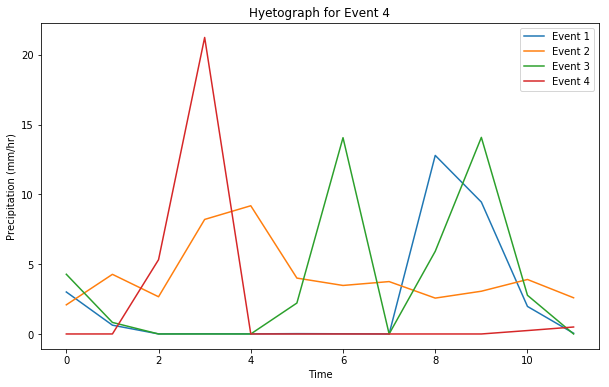

In [97]:
# Plotting hyetographs
plt.figure(figsize=(10, 6))
for i, event_df in enumerate(dimensionless_events):
    event_df.reset_index(inplace=True, drop=True)
    plt.plot(event_df.index, event_df['precipitation (mm/hr)'], label=f'Event {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Precipitation (mm/hr)')
    plt.title(f'Hyetograph for Event {i+1}')
    plt.legend()
plt.show()
